In [1]:
%run ~/relmapping/annot/notebooks/__init__.ipynb

/mnt/home3/jj374/anaconda36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


os.getcwd(): /mnt/b2/scratch/ahringer/jj374/lab/relmapping


In [2]:
fp_ = 'wget/genome.cshlp.org/content/suppl/2013/04/25/gr.151571.112.DC1/Supplemental_Table_S2.csv'
df_emb_ = pd.read_csv(fp_)
print('%d records raw' % (len(df_emb_)),)
print(df_emb_['TSS type'].value_counts())
print()
df_emb_ = df_emb_.loc[df_emb_['start position'] == df_emb_['start position']]
print('%d records with start position set' % (len(df_emb_)),)
print(df_emb_['TSS type'].value_counts())

12520 records raw
outron    7310
exon      4904
Name: TSS type, dtype: int64

12214 records with start position set
outron    7310
exon      4904
Name: TSS type, dtype: int64


http://genome.cshlp.org/content/23/8/1348.long
> Among 13,336 genes having Gaussian TSS peaks in the region of length 3000 bp upstream of their translation initiation sites, 7351 genes (55.1%) had only Gaussian outron-TSSs and were therefore defined as trans-spliced genes, and 4906 genes (36.8%) having only Gaussian exon-TSSs were categorized as non-trans-spliced genes (Fig. 1C).

Are 7310 / 4904 close enough to 7351 / 4906?

> For genes that could be defined unambiguously as trans-spliced or non-trans-spliced, we assigned gene-unique representative outron/exon-TSSs with the maximum number of aligned reads. This allowed us to pursue further analysis in parallel with (1) all Gaussian peaks as TSSs (“The Gaussian Peak Collection”), and (2) representative gene-unique TSSs (one for each gene).

In [3]:
df_emb = pd.DataFrame()
df_emb['chrom'] = df_emb_['chr']
df_emb['start'] = list(map(int, df_emb_['start position']))
df_emb['end'] = df_emb['start'] + 1
df_emb['name'] = df_emb_['common gene name']
df_emb['score'] = df_emb_['number of aligned reads in the best-fit Gaussian distribution']
df_emb['strand'] = df_emb_['strand']
df_emb['stage'] = 'embryo'
df_emb.head()

,chrom,start,end,name,score,strand,stage
0,chrI,10640,10641,Y74C9A.3,29.0,-,embryo
1,chrI,11285,11286,nlp-40,16.0,+,embryo
2,chrI,27287,27288,Y74C9A.4,30.0,-,embryo
3,chrI,43530,43531,Y74C9A.1,17.0,+,embryo
4,chrI,47202,47203,Y48G1C.12,50.0,+,embryo


In [4]:
fp_ = 'wget/genome.cshlp.org/content/suppl/2013/04/25/gr.151571.112.DC1/Supplemental_Table_S3.csv'
df_ad_ = pd.read_csv(fp_)
print('%d records raw' % (len(df_ad_)),)
print(df_ad_['TSS type'].value_counts())
print()
df_ad_ = df_ad_.loc[df_ad_['start position'] == df_ad_['start position']].reset_index(drop=True)
print('%d records with start position set' % (len(df_ad_)),)
print(df_ad_['TSS type'].value_counts())

12520 records raw
exon      2837
outron    2728
Name: TSS type, dtype: int64

5565 records with start position set
exon      2837
outron    2728
Name: TSS type, dtype: int64


In [5]:
df_ad = pd.DataFrame()
df_ad['chrom'] = df_ad_['chr']
df_ad['start'] = list(map(int, df_ad_['start position']))
df_ad['end'] = df_ad['start'] + 1
df_ad['name'] = df_ad_['common gene name']
df_ad['score'] = df_ad_['number of aligned reads in the best-fit Gaussian distribution']
df_ad['strand'] = df_ad_['strand']
df_ad['stage'] = 'adult'
df_ad.head()

,chrom,start,end,name,score,strand,stage
0,chrI,11289,11290,nlp-40,11.0,+,adult
1,chrI,91223,91224,Y48G1C.9,59.0,+,adult
2,chrI,93010,93011,Y48G1C.1,470.0,+,adult
3,chrI,109000,109001,Y48G1C.8,123.0,-,adult
4,chrI,110310,110311,rab-11.1,63.0,-,adult


In [6]:
df_ = pd.concat([df_emb, df_ad], axis=0)\
    .sort_values(['chrom', 'start', 'end', 'strand']).reset_index(drop=True)
print('%d emb representative TSSs' % (len(df_emb),))
print('%d adult representative TSSs' % (len(df_ad),))

df_saito_emb_ad = BedTool.from_dataframe(df_).merge(s=True, c='4,5,7', o='distinct,sum,distinct').to_dataframe()
print('%d pooled Embryo+adult records' % (len(df_saito_emb_ad),))

df_saito_emb_ad.columns = ('chrom', 'start', 'end', 'strand', 'name', 'score', 'stage')
df_saito_emb_ad['stage'].value_counts()

12214 emb representative TSSs
5565 adult representative TSSs
16011 pooled Embryo+adult records


embryo          10446
adult            3797
adult,embryo     1768
Name: stage, dtype: int64

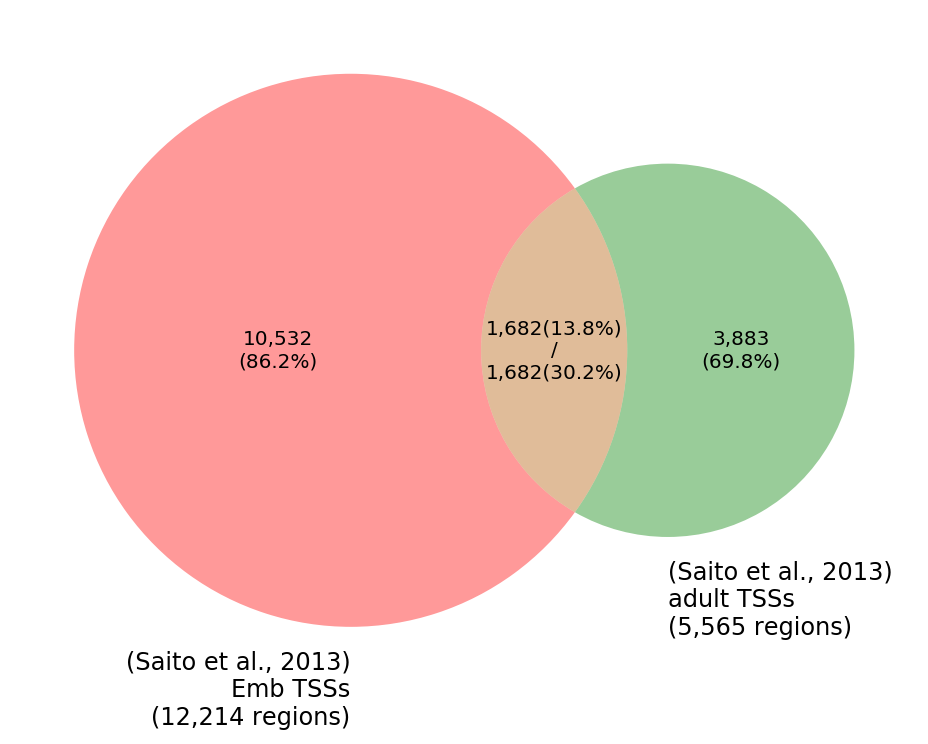

In [7]:
gv = yp.GenomicVenn2(
    BedTool.from_dataframe(df_emb),
    BedTool.from_dataframe(df_ad),
    label_a='(Saito et al., 2013)\nEmb TSSs',
    label_b='(Saito et al., 2013)\nadult TSSs',
)
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
gv.plot()

In [8]:
fp_ = 'annot/Fig2S5_tss/Saito2013/Saito2013_tss.bed'
write_gffbed(fp_,
    chrom = df_saito_emb_ad['chrom'],
    start = df_saito_emb_ad['start'],
    end = df_saito_emb_ad['end'],
    name = df_saito_emb_ad['name'],
    strand = df_saito_emb_ad['strand'],
    attr = df_saito_emb_ad[['name', 'stage']],
)

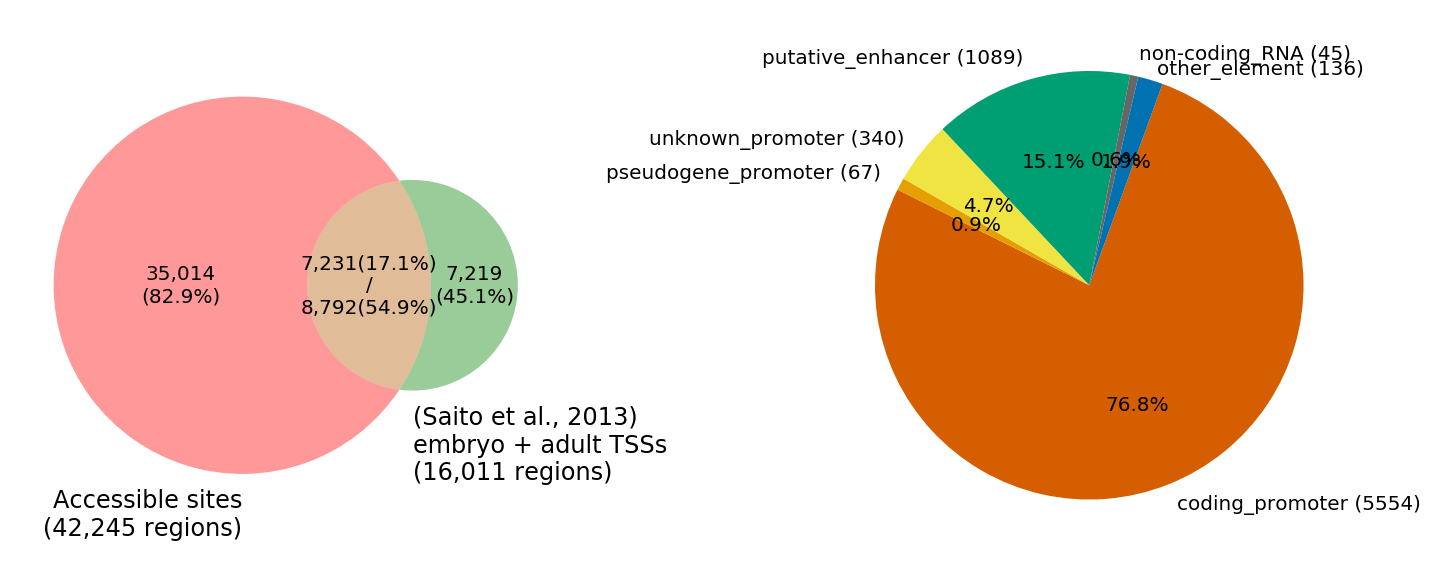

In [10]:
# (Saito et al., 2013)
df_regl_ = regl_mode(flank_len=150)
df_regl_['annot'] = regl_()['annot']

gv = yp.GenomicVenn2(
    BedTool.from_dataframe(df_regl_),
    BedTool.from_dataframe(df_saito_emb_ad[yp.NAMES_BED3]),
    label_a='Accessible sites',
    label_b='(Saito et al., 2013)\nembryo + adult TSSs',
)

plt.figure(figsize=(12,6)).subplots_adjust(wspace=0.5)
plt.subplot(1,2,1)
gv.plot()

plt.subplot(1,2,2)
annot_count_ = gv.df_a_with_b['name'].value_counts()[config['annot']]
annot_count_.index = [
    'coding_promoter',
    'pseudogene_promoter',
    'unknown_promoter',
    'putative_enhancer',
    'non-coding_RNA',
    '\nother_element'
]
#plt.title('Annotation of %d accessible sites that overlap a TSS from (Saito et al., 2013)' % (len(gv.df_a_with_b),))
plt.pie(
    annot_count_.values,
    labels = ['%s (%d)' % (l, c) for l, c in annot_count_.iteritems()],
    colors=[yp.RED, yp.ORANGE, yp.YELLOW, yp.GREEN, '0.4', yp.BLUE],
    counterclock=False,
    startangle=70,
    autopct='%.1f%%',
);
plt.gca().set_aspect('equal')
plt.savefig('annot/Fig2S5_tss/Saito2013_annot.pdf', bbox_inches='tight', transparent=True)